In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [21]:
# Configuration parameters
IMG_SIZE = 224  # Standard input size for EfficientNetB0
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 5  # 5 WBC types
LEARNING_RATE = 0.001

In [22]:
# Paths - Update these according to your Kaggle setup
DATA_PATH = "/kaggle/input/uni-wbc-dataset/UniWBC"  # path
TRAIN_PATH = os.path.join(DATA_PATH, 'Train')
VAL_PATH = os.path.join(DATA_PATH, 'Val')
TEST_PATH = os.path.join(DATA_PATH, 'Test')

In [23]:
# Function to create data generators
def create_data_generators():
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Just rescaling for validation and test
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    validation_generator = val_test_datagen.flow_from_directory(
        VAL_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [24]:
# Function to create a custom CNN backbone (as a replacement for EfficientNet if download fails)
def create_custom_cnn(inputs):
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    previous_block_activation = x  # Set aside residual

    # 8 blocks
    for size in [128, 128, 256, 256, 512, 512, 728, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding='same')(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    
    return x

In [25]:
# Function to create a simplified Vision Transformer block
def vit_block(inputs, num_heads=8, projection_dim=64):
    # Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # Multi-head attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim
    )(x, x)
    
    # Skip connection 1
    x = layers.Add()([attention_output, inputs])
    
    # Normalization
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # MLP
    y = layers.Dense(projection_dim * 2, activation='gelu')(y)
    y = layers.Dense(projection_dim)(y)
    
    # Skip connection 2
    outputs = layers.Add()([y, x])
    
    return outputs

In [26]:
# Function to create a simplified GNN-like block using convolutional operations
def simplified_gnn_block(inputs, filters=128):
    # Instead of using explicit graph operations, we'll use convolutions
    # to simulate message passing between neighboring pixels
    
    # Initial feature extraction
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(inputs)
    
    # Simulate message passing with depthwise separable convolutions
    # This allows information to flow between neighboring pixels
    x = layers.SeparableConv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Another round of "message passing"
    x = layers.SeparableConv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Residual connection
    if inputs.shape[-1] == filters:
        x = layers.Add()([x, inputs])
    else:
        # If channels don't match, use 1x1 conv to match dimensions
        shortcut = layers.Conv2D(filters, 1, padding='same')(inputs)
        x = layers.Add()([x, shortcut])
    
    return x


In [27]:
# Create the Tri-Net model
def create_tri_net_model():
    # Input layer
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # 1. EfficientNet Branch or Custom CNN if download fails
    try:
        print("Attempting to load pre-trained EfficientNetB0...")
        # Try to load pre-trained EfficientNetB0
        efficientnet = EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_tensor=inputs
        )
        
        # Freeze the EfficientNet layers initially
        for layer in efficientnet.layers:
            layer.trainable = False
        
        # Get the output from EfficientNet
        x_eff = efficientnet.output
        
    except Exception as e:
        print(f"Error loading pre-trained EfficientNetB0: {e}")
        print("Using custom CNN backbone instead...")
        
        # Use custom CNN instead
        x_eff = create_custom_cnn(inputs)
    
    # Global pooling and dense layer for the first branch
    x_eff = layers.GlobalAveragePooling2D()(x_eff)
    x_eff = layers.Dense(256, activation='relu')(x_eff)
    
    # 2. Vision Transformer Branch
    # Extract patches from the input image
    patch_size = 16
    patches = layers.Conv2D(
        filters=64,
        kernel_size=patch_size,
        strides=patch_size,
        padding='valid'
    )(inputs)
    
    # Reshape patches for transformer
    patch_dim = patches.shape[1] * patches.shape[2]
    patches = layers.Reshape((patch_dim, 64))(patches)
    
    # Add position embeddings
    positions = tf.range(start=0, limit=patch_dim, delta=1)
    position_embedding = layers.Embedding(input_dim=patch_dim, output_dim=64)(positions)
    patches = patches + position_embedding
    
    # Apply Transformer blocks
    x_vit = vit_block(patches)
    x_vit = vit_block(x_vit)
    
    # Global pooling
    x_vit = layers.GlobalAveragePooling1D()(x_vit)
    x_vit = layers.Dense(256, activation='relu')(x_vit)
    
    # 3. "GNN-like" Branch using convolutions
    # Extract features using a few convolutional layers
    x_gnn = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x_gnn = layers.MaxPooling2D(2)(x_gnn)
    x_gnn = layers.Conv2D(64, 3, activation='relu', padding='same')(x_gnn)
    x_gnn = layers.MaxPooling2D(2)(x_gnn)
    
    # Apply our simplified GNN-like blocks
    x_gnn = simplified_gnn_block(x_gnn, filters=64)
    x_gnn = layers.MaxPooling2D(2)(x_gnn)
    x_gnn = simplified_gnn_block(x_gnn, filters=128)
    
    # Global pooling
    x_gnn = layers.GlobalAveragePooling2D()(x_gnn)
    x_gnn = layers.Dense(256, activation='relu')(x_gnn)
    
    # Combine all three branches
    combined = layers.Concatenate()([x_eff, x_vit, x_gnn])
    
    # Add some fully connected layers
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [28]:
# Function to train the model
def train_model(model, train_generator, validation_generator):
    # Enable GPU
    import tensorflow as tf
    
    # Check for GPU availability without trying to modify memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print(f"GPU is available: {physical_devices}")
        # Note: We're not setting memory growth since runtime is already initialized
    else:
        print("No GPU found. Training will use CPU.")
    
    # Set up mixed precision training for faster GPU processing
    if len(physical_devices) > 0:
        try:
            # Try to set mixed precision, but handle if policy is already set
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print("Using mixed precision training")
        except RuntimeError:
            print("Mixed precision policy already set or cannot be modified")
    
    # Define callbacks
    checkpoint = ModelCheckpoint(
        'best_tri_net_model_Training.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=40,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=40,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train the model (removed workers and use_multiprocessing)
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )
    
    return history

In [29]:
# # Function to train the model
# def train_model(model, train_generator, validation_generator):
#     # Define callbacks
#     checkpoint = ModelCheckpoint(
#         'best_tri_net_model.keras',
#         monitor='val_accuracy',
#         save_best_only=True,
#         mode='max',
#         verbose=1
#     )
    
#     early_stopping = EarlyStopping(
#         monitor='val_accuracy',
#         patience=5,
#         restore_best_weights=True,
#         verbose=1
#     )
    
#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.2,
#         patience=5,
#         min_lr=1e-6,
#         verbose=1
#     )
    
#     # Train the model
#     history = model.fit(
#         train_generator,
#         epochs=EPOCHS,
#         validation_data=validation_generator,
#         callbacks=[checkpoint, early_stopping, reduce_lr]
#     )
    
#     return history

In [30]:
# Function to evaluate the model
def evaluate_model(model, test_generator):
    # Enable GPU
    import tensorflow as tf
    
    # Check for GPU availability without modifying memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print(f"GPU is available for evaluation: {physical_devices}")
    else:
        print("No GPU found. Evaluation will use CPU.")
    
    # Set batch size for prediction - larger batch sizes are more efficient on GPU
    batch_size = 32
    if len(physical_devices) > 0:
        batch_size = 64  # Use larger batch for GPU
    
    # Get predictions with GPU acceleration
    test_generator.reset()
    
    # Ensure the generator's batch size is appropriate for GPU
    original_batch_size = test_generator.batch_size
    test_generator.batch_size = batch_size
    
    # Use predict (removed workers and use_multiprocessing)
    y_pred = model.predict(
        test_generator,
        verbose=1
    )
    
    # Restore original batch size
    test_generator.batch_size = original_batch_size
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    # Get class labels
    class_indices = test_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=list(class_indices.keys())))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_indices))
    plt.xticks(tick_marks, list(class_indices.keys()), rotation=45)
    plt.yticks(tick_marks, list(class_indices.keys()))
    
    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return y_true, y_pred_classes

In [31]:
# # Function to evaluate the model
# def evaluate_model(model, test_generator):
#     # Get predictions
#     test_generator.reset()
#     y_pred = model.predict(test_generator, verbose=1)
#     y_pred_classes = np.argmax(y_pred, axis=1)
    
#     # Get true labels
#     y_true = test_generator.classes
    
#     # Get class labels
#     class_indices = test_generator.class_indices
#     class_labels = {v: k for k, v in class_indices.items()}
    
#     # Print classification report
#     print("Classification Report:")
#     print(classification_report(y_true, y_pred_classes, target_names=list(class_indices.keys())))
    
#     # Create confusion matrix
#     cm = confusion_matrix(y_true, y_pred_classes)
    
#     # Plot confusion matrix
#     plt.figure(figsize=(10, 8))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.colorbar()
#     tick_marks = np.arange(len(class_indices))
#     plt.xticks(tick_marks, list(class_indices.keys()), rotation=45)
#     plt.yticks(tick_marks, list(class_indices.keys()))
    
#     # Add text annotations to the confusion matrix
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             plt.text(j, i, format(cm[i, j], 'd'),
#                     horizontalalignment="center",
#                     color="white" if cm[i, j] > thresh else "black")
    
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.savefig('confusion_matrix.png')
#     plt.show()
    
#     return y_true, y_pred_classes


In [32]:
# Function to fine-tune the model
def fine_tune_model(model, train_generator, validation_generator):
    print("Fine-tuning the model...")
    
    # Enable GPU
    import tensorflow as tf
    
    # Check for GPU availability without modifying memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print(f"GPU is available for fine-tuning: {physical_devices}")
        
        # Set up mixed precision for fine-tuning
        try:
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print("Using mixed precision for fine-tuning")
        except RuntimeError:
            print("Mixed precision policy already set or cannot be modified")
    else:
        print("No GPU found. Fine-tuning will use CPU.")
    
    # Check if the model contains an EfficientNet or a custom CNN
    has_efficientnet = any(isinstance(layer, tf.keras.models.Model) for layer in model.layers)
    
    if has_efficientnet:
        # Unfreeze some of the EfficientNet layers if available
        for layer in model.layers:
            if isinstance(layer, tf.keras.models.Model):  # This is the EfficientNet model
                # Unfreeze the last 20 layers
                for i, l in enumerate(layer.layers):
                    if i >= len(layer.layers) - 20:
                        l.trainable = True
    
    # Compile with a lower learning rate
    # Use float32 for the optimizer when using mixed precision
    if len(physical_devices) > 0:
        try:
            # Try to use LossScaleOptimizer, but handle if it's not compatible
            optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10)
            optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
        except Exception:
            # Fallback to regular optimizer if there's any issue
            optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10)
            print("Using standard optimizer without loss scaling")
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10)
        
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Define callbacks
    checkpoint = ModelCheckpoint(
        'best_fine_tuned_model_fining.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=30,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=30,
        min_lr=1e-7,
        verbose=1
    )
    
    # Train the model (removed workers and use_multiprocessing)
    history = model.fit(
        train_generator,
        epochs=40,  # Fewer epochs for fine-tuning
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )
    
    return history

In [33]:
# # Function to fine-tune the model
# def fine_tune_model(model, train_generator, validation_generator):
#     print("Fine-tuning the model...")
    
#     # Enable GPU
#     import tensorflow as tf
    
#     # Check for GPU availability without modifying memory growth
#     physical_devices = tf.config.list_physical_devices('GPU')
#     if len(physical_devices) > 0:
#         print(f"GPU is available for fine-tuning: {physical_devices}")
#         # Not setting memory growth as runtime is already initialized
        
#         # Set up mixed precision for fine-tuning
#         try:
#             policy = tf.keras.mixed_precision.Policy('mixed_float16')
#             tf.keras.mixed_precision.set_global_policy(policy)
#             print("Using mixed precision for fine-tuning")
#         except RuntimeError:
#             print("Mixed precision policy already set or cannot be modified")
#     else:
#         print("No GPU found. Fine-tuning will use CPU.")
    
#     # Check if the model contains an EfficientNet or a custom CNN
#     has_efficientnet = any(isinstance(layer, tf.keras.models.Model) for layer in model.layers)
    
#     if has_efficientnet:
#         # Unfreeze some of the EfficientNet layers if available
#         for layer in model.layers:
#             if isinstance(layer, tf.keras.models.Model):  # This is the EfficientNet model
#                 # Unfreeze the last 20 layers
#                 for i, l in enumerate(layer.layers):
#                     if i >= len(layer.layers) - 20:
#                         l.trainable = True
    
#     # Compile with a lower learning rate
#     # Use float32 for the optimizer when using mixed precision
#     if len(physical_devices) > 0:
#         try:
#             # Try to use LossScaleOptimizer, but handle if it's not compatible
#             optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10)
#             optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
#         except Exception:
#             # Fallback to regular optimizer if there's any issue
#             optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10)
#             print("Using standard optimizer without loss scaling")
#     else:
#         optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10)
        
#     model.compile(
#         optimizer=optimizer,
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
    
#     # Define callbacks
#     checkpoint = ModelCheckpoint(
#         'best_fine_tuned_model.keras',
#         monitor='val_accuracy',
#         save_best_only=True,
#         mode='max',
#         verbose=1
#     )
    
#     early_stopping = EarlyStopping(
#         monitor='val_accuracy',
#         patience=5,
#         restore_best_weights=True,
#         verbose=1
#     )
    
#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.2,
#         patience=5,
#         min_lr=1e-7,
#         verbose=1
#     )
    
#     # Train the model with GPU optimization
#     history = model.fit(
#         train_generator,
#         epochs=10,  # Fewer epochs for fine-tuning
#         validation_data=validation_generator,
#         callbacks=[checkpoint, early_stopping, reduce_lr],
#         workers=4,  # Parallel workers for data loading
#         use_multiprocessing=True  # Enable multiprocessing
#     )
    
#     return history

In [34]:
# # Function to fine-tune the model
# def fine_tune_model(model, train_generator, validation_generator):
#     print("Fine-tuning the model...")
    
#     # Check if the model contains an EfficientNet or a custom CNN
#     has_efficientnet = any(isinstance(layer, tf.keras.models.Model) for layer in model.layers)
    
#     if has_efficientnet:
#         # Unfreeze some of the EfficientNet layers if available
#         for layer in model.layers:
#             if isinstance(layer, tf.keras.models.Model):  # This is the EfficientNet model
#                 # Unfreeze the last 20 layers
#                 for i, l in enumerate(layer.layers):
#                     if i >= len(layer.layers) - 20:
#                         l.trainable = True
    
#     # Compile with a lower learning rate
#     model.compile(
#         optimizer=optimizers.Adam(learning_rate=LEARNING_RATE / 10),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
    
#     # Define callbacks
#     checkpoint = ModelCheckpoint(
#         'best_fine_tuned_model.keras',
#         monitor='val_accuracy',
#         save_best_only=True,
#         mode='max',
#         verbose=1
#     )
    
#     early_stopping = EarlyStopping(
#         monitor='val_accuracy',
#         patience=5,
#         restore_best_weights=True,
#         verbose=1
#     )
    
#     reduce_lr = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.2,
#         patience=5,
#         min_lr=1e-7,
#         verbose=1
#     )
    
#     # Train the model
#     history = model.fit(
#         train_generator,
#         epochs=10,  # Fewer epochs for fine-tuning
#         validation_data=validation_generator,
#         callbacks=[checkpoint, early_stopping, reduce_lr]
#     )
    
#     return history

In [35]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [36]:
def main():
    print("Creating data generators...")
    train_generator, validation_generator, test_generator = create_data_generators()
    
    print("Class mapping:", train_generator.class_indices)
    
    print("Creating Tri-Net model...")
    model = create_tri_net_model()
    model.summary()
    
    print("Training model (initial phase)...")
    history = train_model(model, train_generator, validation_generator)
    
    print("Plotting training history (initial phase)...")
    plot_training_history(history)
    
    print("Fine-tuning the model...")
    fine_tune_history = fine_tune_model(model, train_generator, validation_generator)
    
    print("Plotting training history (fine-tuning phase)...")
    plot_training_history(fine_tune_history)
    
    print("Evaluating model on test data...")
    y_true, y_pred = evaluate_model(model, test_generator)
    
    print("Saving model...")
    model.save('final_tri_net_model.keras')
    print("Done!")

    # Make models available for download in Kaggle
    from IPython.display import FileLink
    
    print("Model saved. Download links:")
    print("Final model:")
    display(FileLink('final_tri_net_model.keras'))
    print("Best model from initial training:")
    display(FileLink('best_tri_net_model_Training.keras'))
    print("Best model from fine-tuning:")
    display(FileLink('best_fine_tuned_model_fining.keras'))
    
    print("Done!")

Creating data generators...
Found 500 images belonging to 5 classes.
Found 150 images belonging to 5 classes.
Found 360 images belonging to 5 classes.
Class mapping: {'Baso': 0, 'Eosino': 1, 'Lympho': 2, 'Mono': 3, 'Neutro': 4}
Creating Tri-Net model...
Attempting to load pre-trained EfficientNetB0...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 5,486,568 (20.93 MB)

 Trainable params: 1,436,229 (5.48 MB)

 Non-trainable params: 4,050,339 (15.45 MB)

Training model (initial phase)...
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using mixed precision training
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2774 - loss: 1.6514
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to best_tri_net_model_Training.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.2771 - loss: 1.6517 - val_accuracy: 0.1667 - val_loss: 1.6384 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3162 - loss: 1.5383
Epoch 2: val_accuracy improved from 0.16667 to 0.20000, saving model to best_tri_net_model_Training.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.3175 - loss: 1.5373 - val_accuracy: 0.2000 - val_loss: 1.8700 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3980 - loss: 1.4108
Epoch 3: val_accuracy did not improve from 0.20000
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0

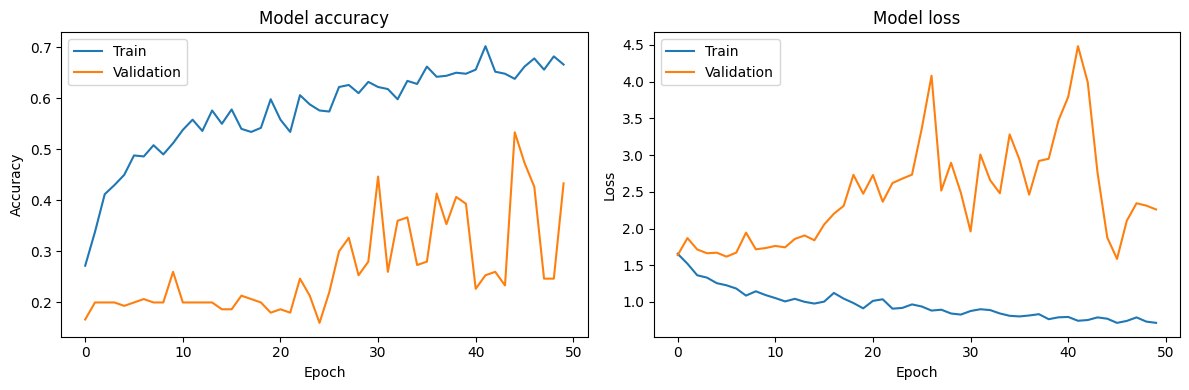

Fine-tuning the model...
Fine-tuning the model...
GPU is available for fine-tuning: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using mixed precision for fine-tuning
Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6768 - loss: 0.7077
Epoch 1: val_accuracy improved from -inf to 0.55333, saving model to best_fine_tuned_model_fining.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6773 - loss: 0.7067 - val_accuracy: 0.5533 - val_loss: 1.5896 - learning_rate: 1.0000e-04
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7407 - loss: 0.5933
Epoch 2: val_accuracy did not improve from 0.55333
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 0.7391 - loss: 0.5964 - val_accuracy: 0.5067 - val_loss: 1.6692 - learning_rate: 1.0000e-04
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6886 - loss: 0.6498
Epoch 3: val_accuracy did not improve from 0.55333
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.6896 - 

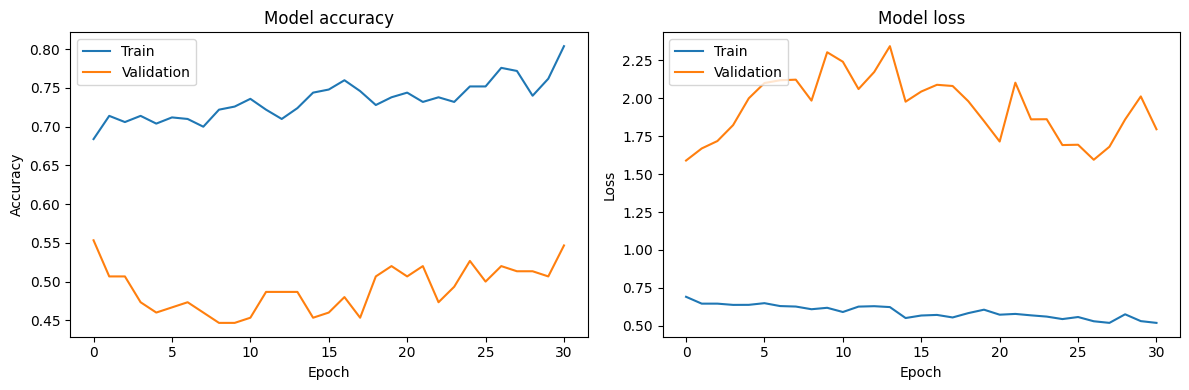

Evaluating model on test data...
GPU is available for evaluation: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step 
Classification Report:
              precision    recall  f1-score   support

        Baso       0.80      0.72      0.75        60
      Eosino       0.47      0.52      0.49        75
      Lympho       0.53      0.59      0.56        75
        Mono       0.51      0.51      0.51        75
      Neutro       0.45      0.40      0.43        75

    accuracy                           0.54       360
   macro avg       0.55      0.55      0.55       360
weighted avg       0.54      0.54      0.54       360



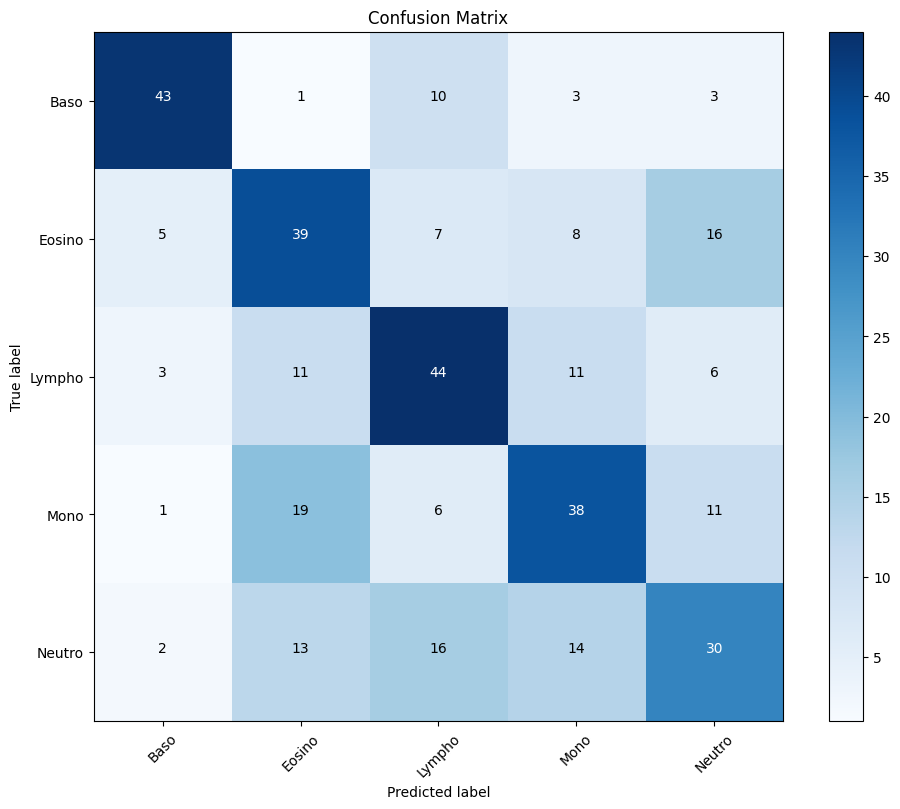

Saving model...
Done!
Model saved. Download links:
Final model:


/kaggle/working/final_tri_net_model.keras

Best model from initial training:


/kaggle/working/best_tri_net_model_Training.keras

Best model from fine-tuning:


/kaggle/working/best_fine_tuned_model_fining.keras

Done!


In [37]:
if __name__ == "__main__":
    main()

# Testing

In [38]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

In [39]:
# Set plot styles for better notebook display
plt.style.use('ggplot')
sns.set_palette("viridis")

In [40]:
# Path to your saved model and testing data
MODEL_PATH = '/kaggle/working/final_tri_net_model.keras'  
TEST_FOLDER = '/kaggle/input/uni-wbc-dataset/UniWBC/Test'   

In [41]:
# Load the trained model
model = load_model(MODEL_PATH)

In [42]:
# Get class names (assuming folder names are class names)
class_names = sorted(os.listdir(TEST_FOLDER))
print(f"Classes: {class_names}")

Classes: ['Baso', 'Eosino', 'Lympho', 'Mono', 'Neutro']


In [43]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

In [44]:
# Lists to store results
true_labels = []
predicted_labels = []
file_paths = []
confidence_scores = []
all_predictions = []  # To store all prediction probabilities for each class


In [45]:
# Process each image in the test folder
for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(TEST_FOLDER, class_name)
    if not os.path.isdir(class_folder):
        continue
        
    print(f"Processing class: {class_name}")
    for image_file in os.listdir(class_folder):
        if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        image_path = os.path.join(class_folder, image_file)
        try:
            # Preprocess the image
            processed_image = preprocess_image(image_path)
            
            # Make prediction
            prediction = model.predict(processed_image, verbose=0)[0]
            predicted_class_idx = np.argmax(prediction)
            confidence = prediction[predicted_class_idx]
            
            # Store results
            true_labels.append(class_idx)
            predicted_labels.append(predicted_class_idx)
            file_paths.append(image_path)
            confidence_scores.append(confidence)
            all_predictions.append(prediction)
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

Processing class: Baso
Processing class: Eosino
Processing class: Lympho
Processing class: Mono
Processing class: Neutro


In [46]:
# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(accuracy)

# Convert class indices to class names
true_class_names = [class_names[idx] for idx in true_labels]
predicted_class_names = [class_names[idx] for idx in predicted_labels]

0.18055555555555555


In [47]:
# Create a DataFrame with the results
results_df = pd.DataFrame({
    'File': [os.path.basename(path) for path in file_paths],
    'True Class': true_class_names,
    'Predicted Class': predicted_class_names,
    'Confidence': [f"{score:.4f}" for score in confidence_scores],
    'Correct': [true == pred for true, pred in zip(true_labels, predicted_labels)]
})

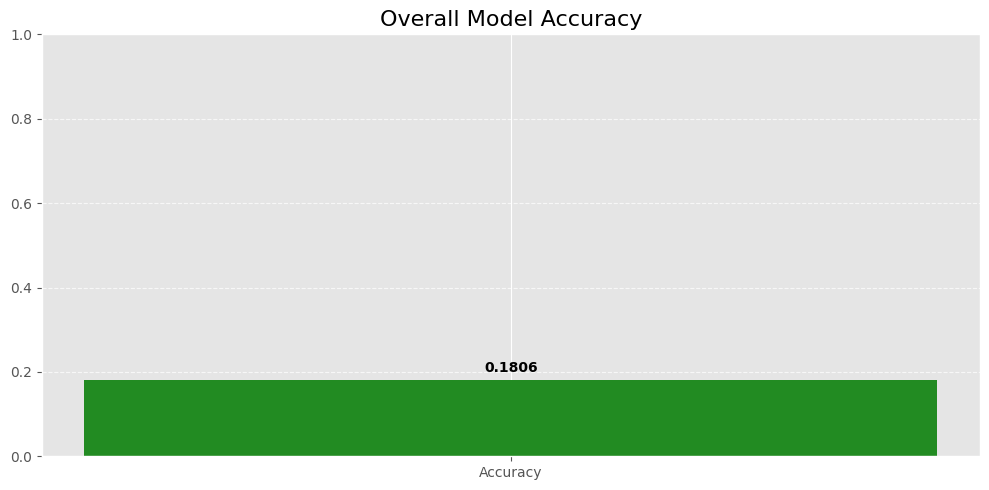

In [48]:
# Display the accuracy with a figure
plt.figure(figsize=(10, 5))
plt.bar(['Accuracy'], [accuracy], color='forestgreen', width=0.6)
plt.ylim(0, 1.0)
for i, v in enumerate([accuracy]):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.title('Overall Model Accuracy', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

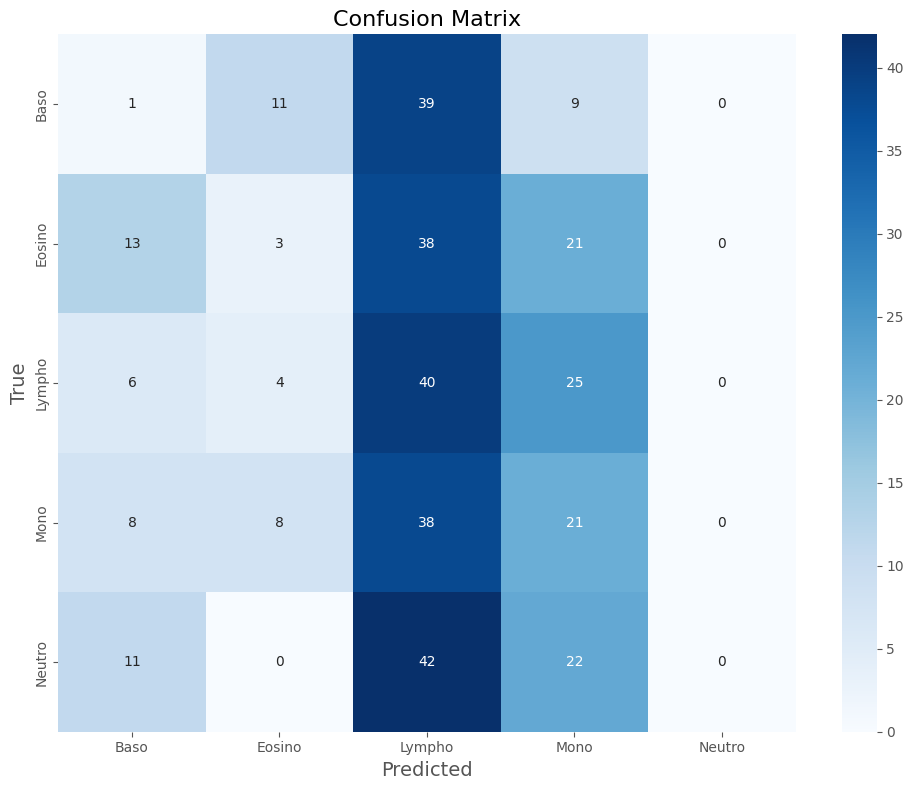

In [49]:
# Confusion Matrix visualization
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


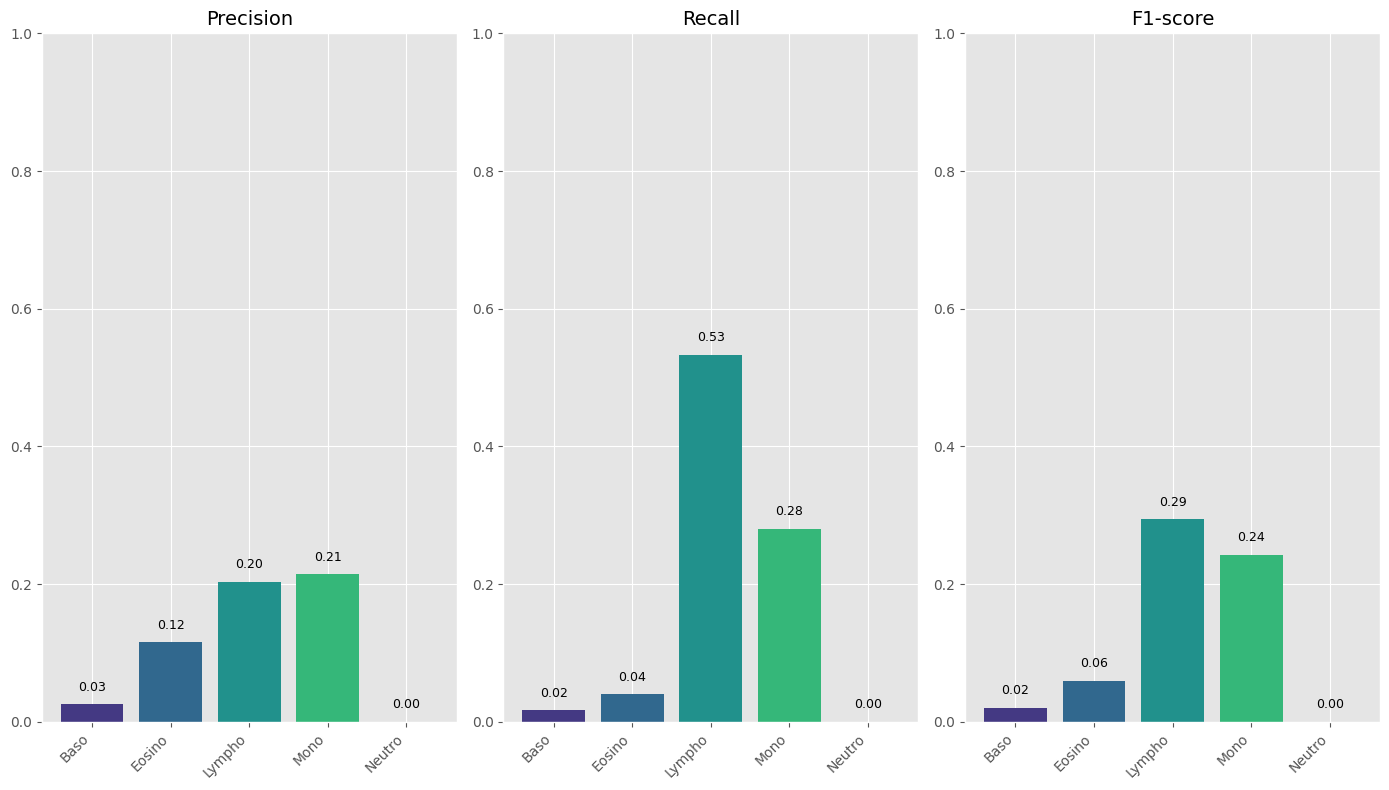

In [51]:
# Classification Report
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
#Visualize classification report metrics
plt.figure(figsize=(14, 8))
metrics_to_plot = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 3, i+1)
    class_metrics = [report[cls][metric] for cls in class_names]
    bars = plt.bar(class_names, class_metrics, color=sns.color_palette("viridis", len(class_names)))
    plt.title(f"{metric.capitalize()}", fontsize=14)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

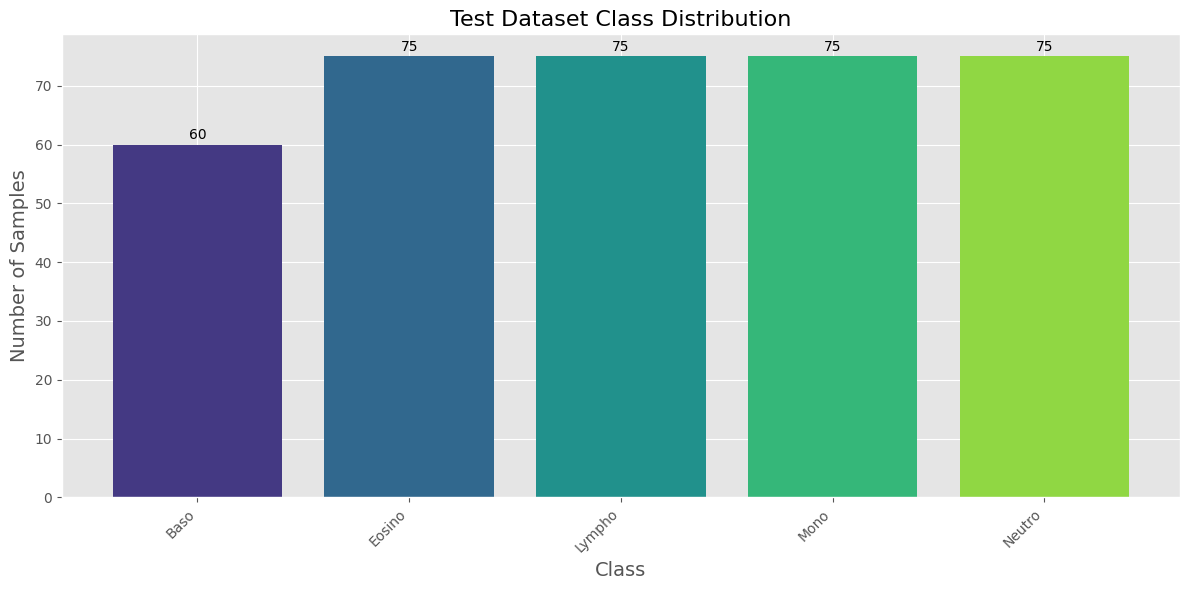

In [52]:
# Class distribution
plt.figure(figsize=(12, 6))
class_counts = pd.Series(true_class_names).value_counts().sort_index()
plt.bar(class_counts.index, class_counts.values, color=sns.color_palette("viridis", len(class_counts)))
plt.title('Test Dataset Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 1, str(v), ha='center')
plt.tight_layout()
plt.show()


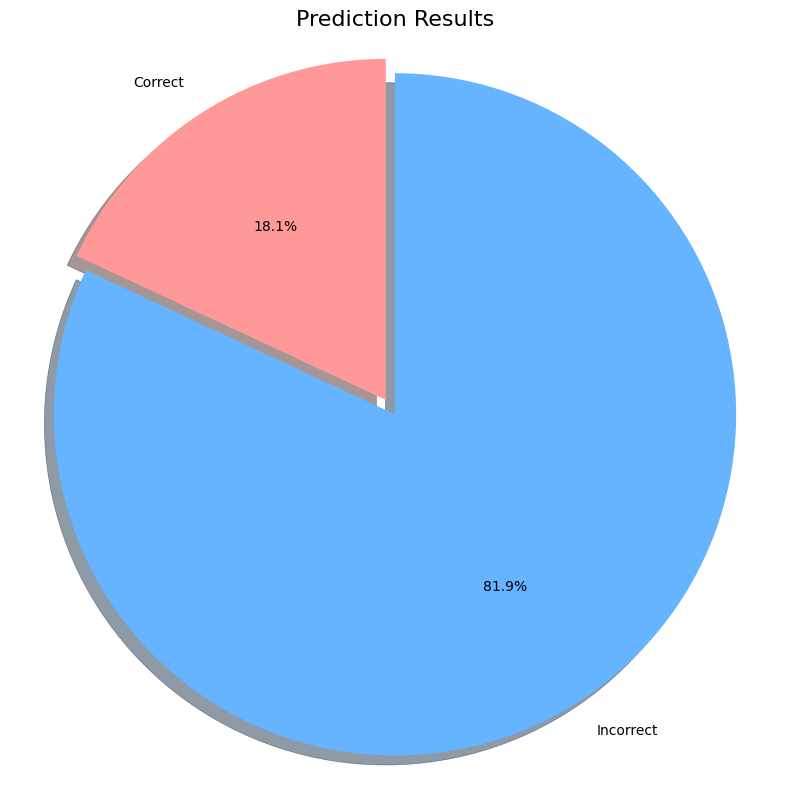

In [53]:
# Correct vs Incorrect predictions visualization
correct_counts = results_df['Correct'].value_counts()
plt.figure(figsize=(8, 8))
colors = ['#ff9999', '#66b3ff']
plt.pie([correct_counts.get(True, 0), correct_counts.get(False, 0)], 
        labels=['Correct', 'Incorrect'],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        explode=(0.05, 0),
        shadow=True)
plt.title('Prediction Results', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [54]:
# Function to visualize sample predictions with confidence levels
def visualize_sample_predictions(num_samples=5):
    # Select random samples
    indices = np.random.choice(len(file_paths), min(num_samples, len(file_paths)), replace=False)
    
    for idx in indices:
        # Create a figure for each prediction
        fig = plt.figure(figsize=(14, 6))
        
        # Display the image
        ax1 = fig.add_subplot(1, 2, 1)
        img = load_img(file_paths[idx], target_size=(224, 224))
        ax1.imshow(img)
        ax1.set_title(f"File: {os.path.basename(file_paths[idx])}", fontsize=12)
        ax1.text(10, 20, f"True: {true_class_names[idx]}", 
                 bbox=dict(facecolor='white', alpha=0.8), fontsize=12)
        ax1.text(10, 50, f"Predicted: {predicted_class_names[idx]}", 
                 bbox=dict(facecolor='green' if true_class_names[idx] == predicted_class_names[idx] else 'red', alpha=0.8),
                 fontsize=12, color='white')
        ax1.axis('off')
        
        # Display confidence scores
        ax2 = fig.add_subplot(1, 2, 2)
        y_pos = np.arange(len(class_names))
        confidence_values = all_predictions[idx]
        
        # Sort by confidence
        sorted_indices = np.argsort(confidence_values)[::-1]
        sorted_class_names = [class_names[i] for i in sorted_indices]
        sorted_confidence = confidence_values[sorted_indices]
        
        bars = ax2.barh(y_pos, sorted_confidence, align='center', 
                color=[plt.cm.viridis(i/len(class_names)) for i in range(len(class_names))])
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(sorted_class_names)
        ax2.invert_yaxis()  # labels read top-to-bottom
        ax2.set_xlabel('Confidence Score')
        ax2.set_title('Prediction Confidence by Class')
        
        # Add confidence values on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax2.text(max(0.01, width - 0.1), bar.get_y() + bar.get_height()/2, 
                    f'{width:.4f}', va='center', color='white' if width > 0.3 else 'black',
                    fontweight='bold')
        
        plt.tight_layout()
        plt.show()



Sample Predictions with Confidence Levels:


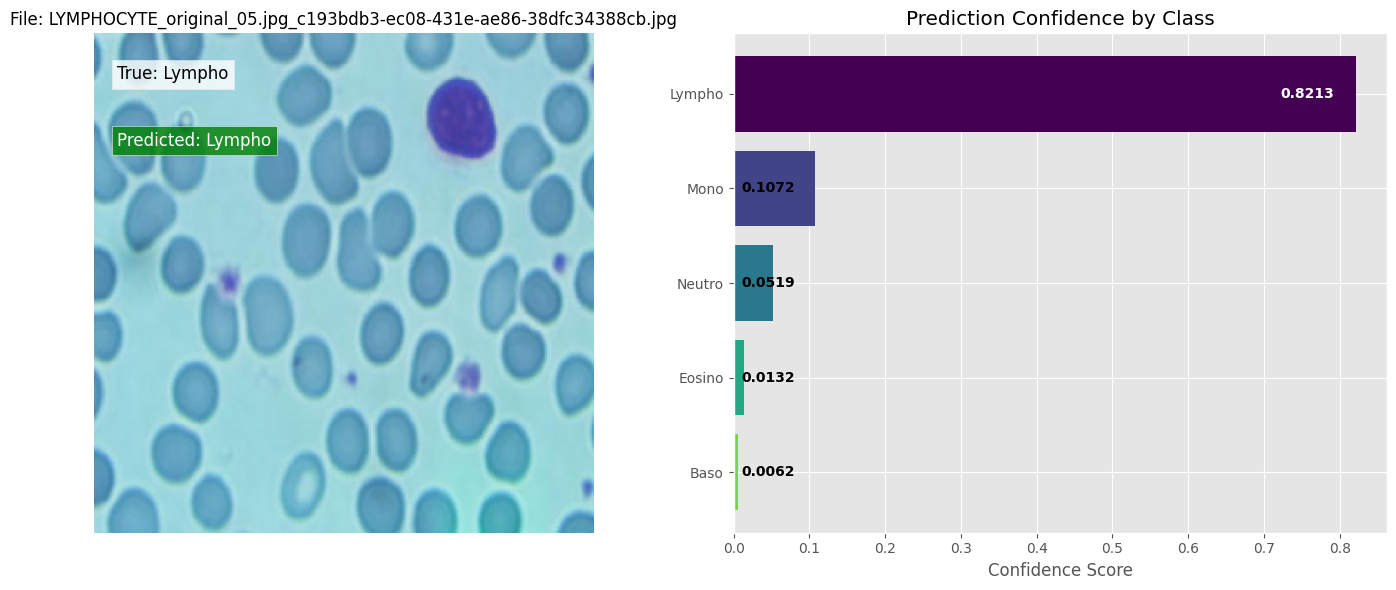

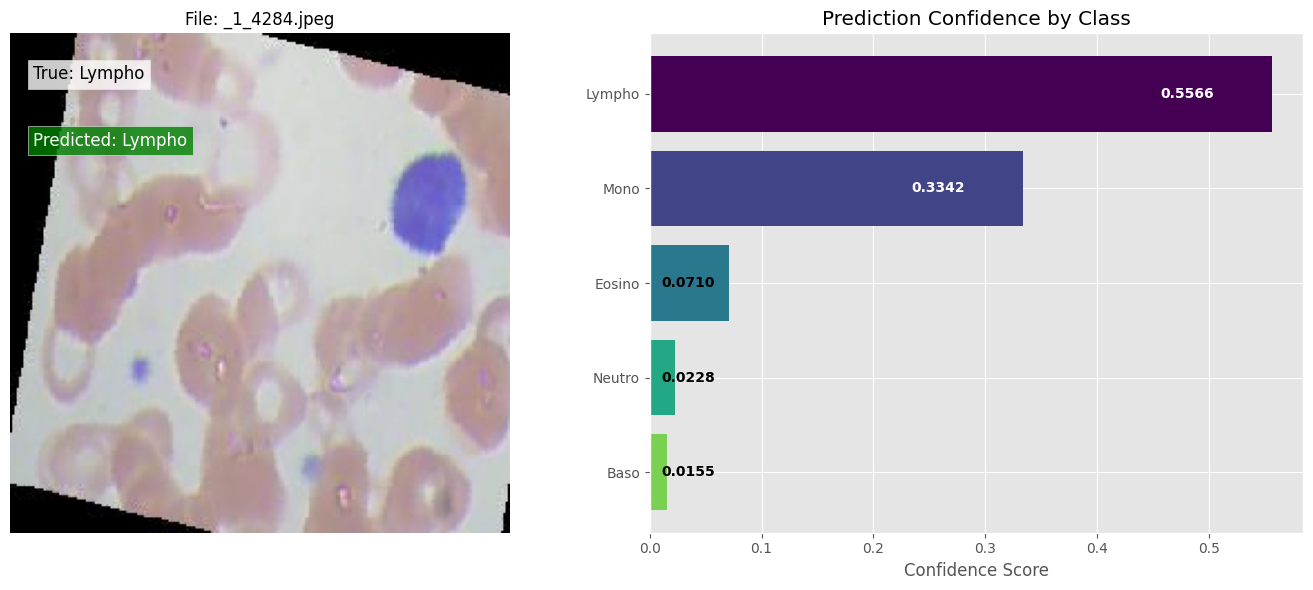

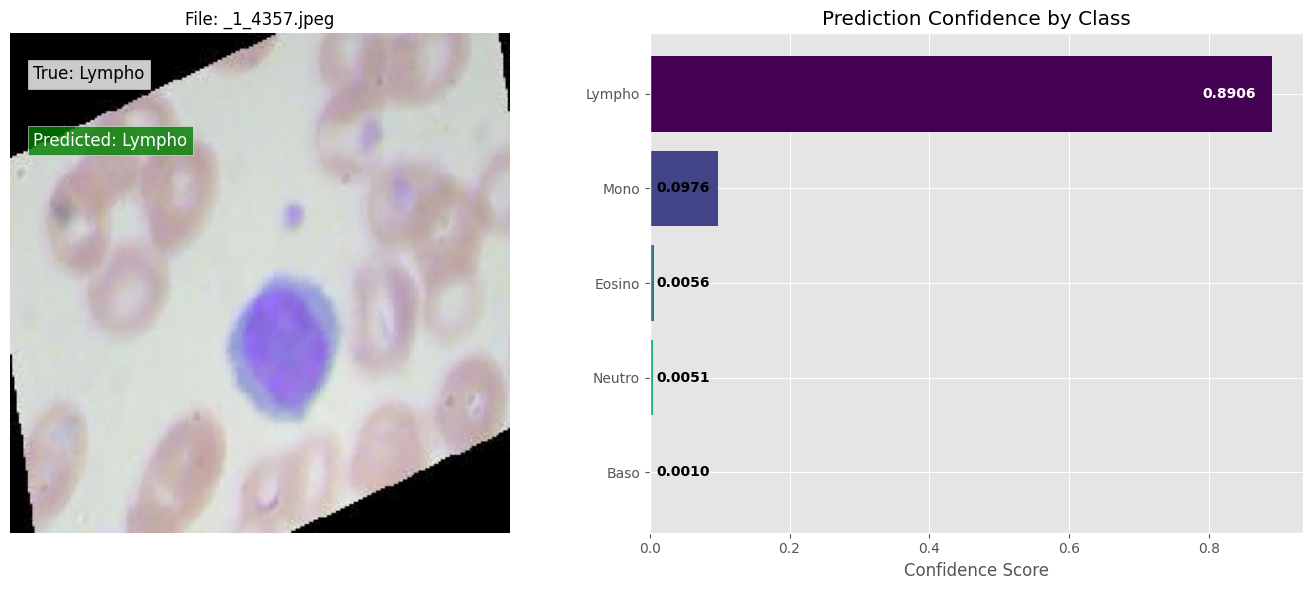

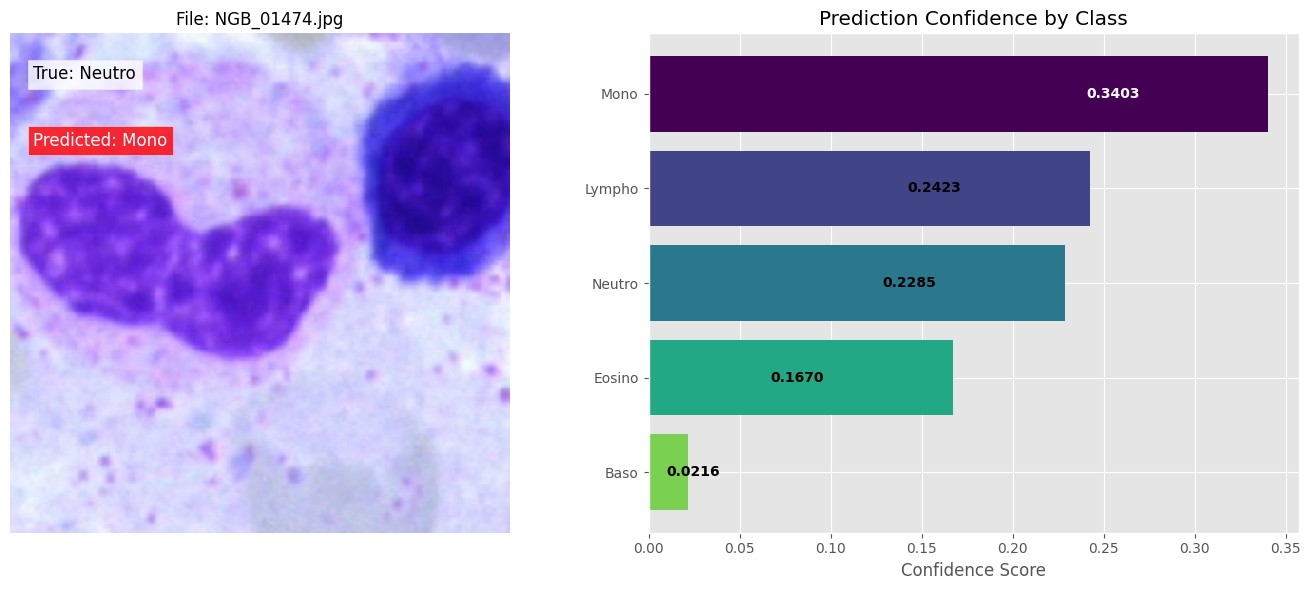

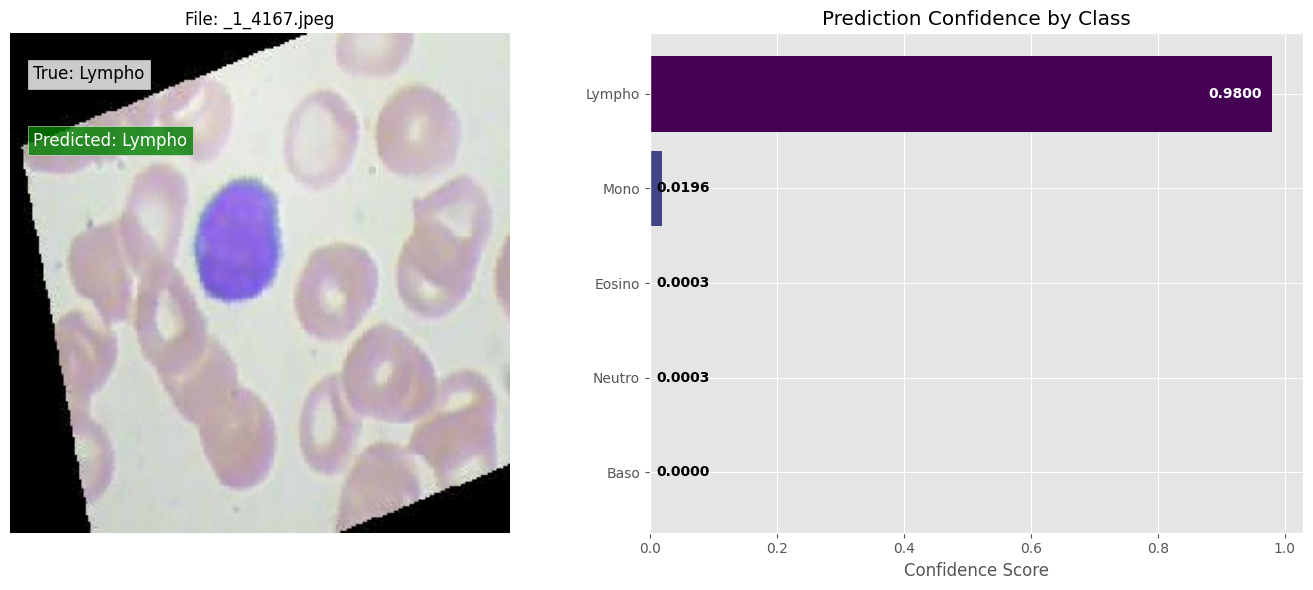

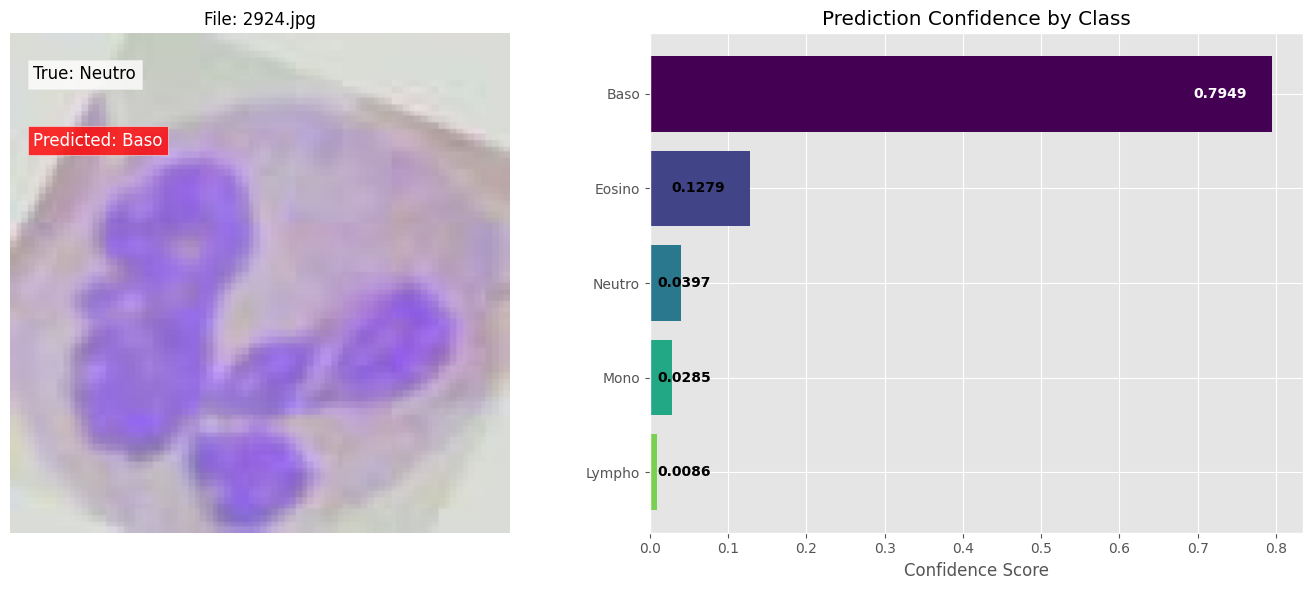

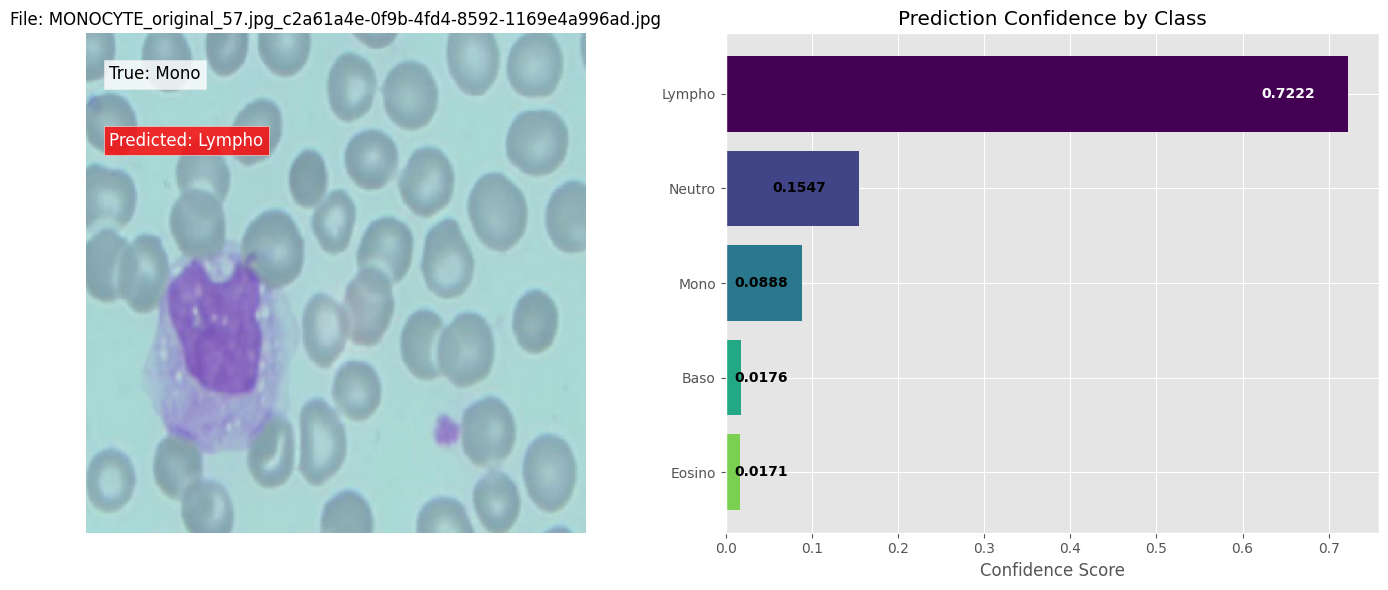

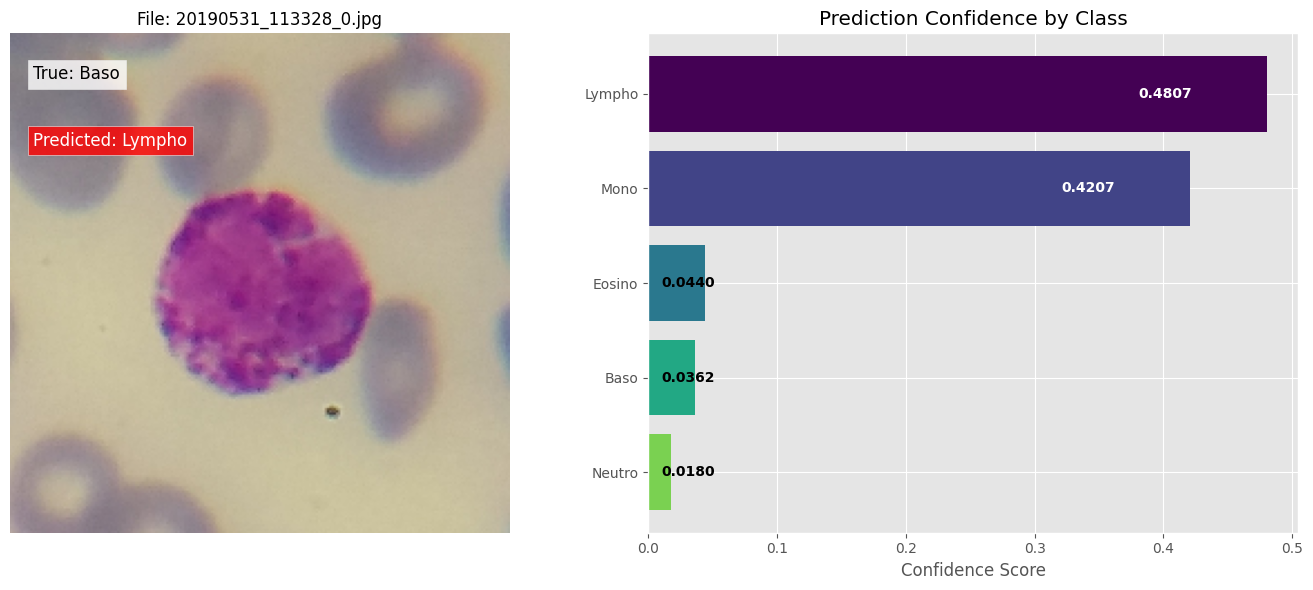

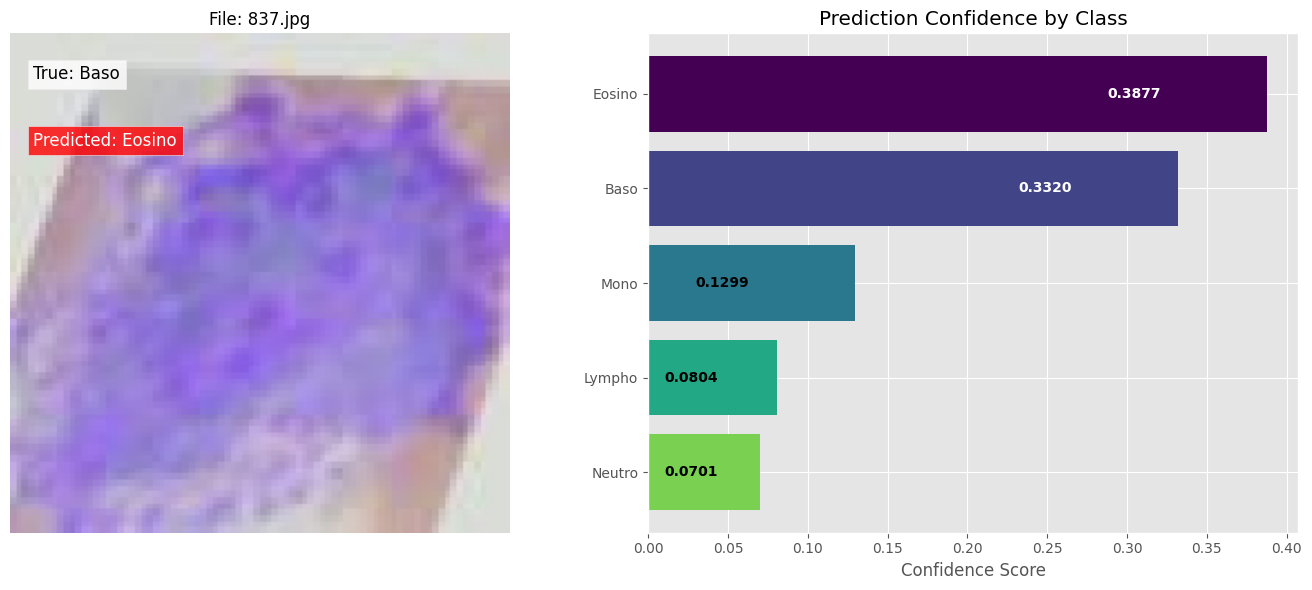

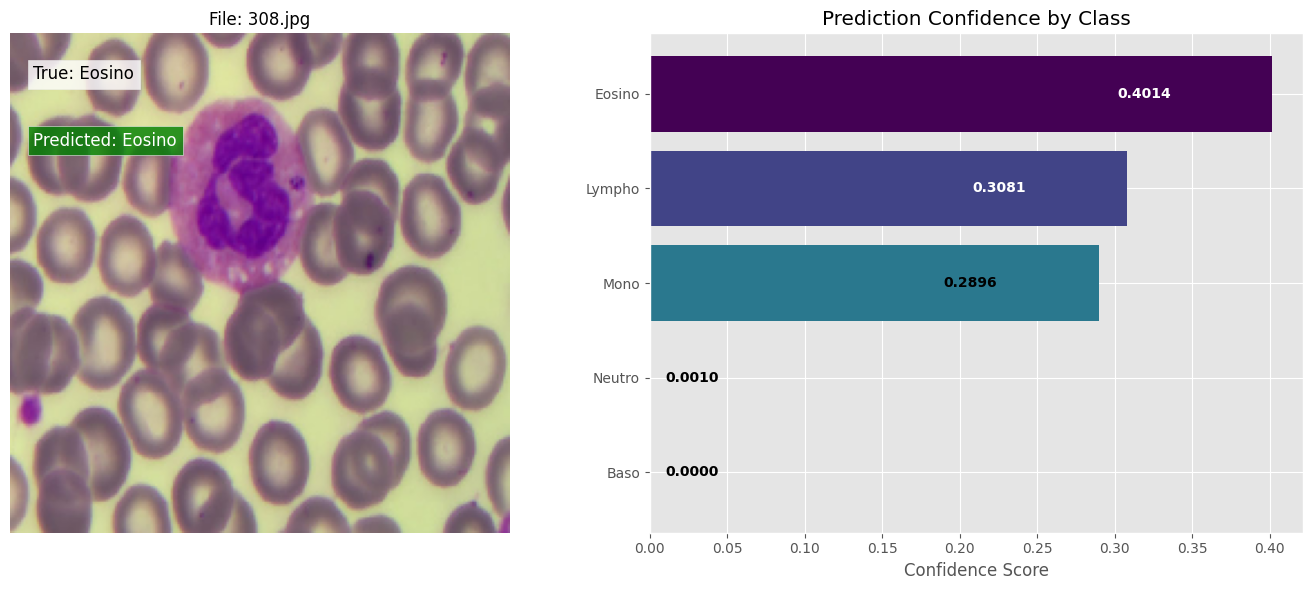

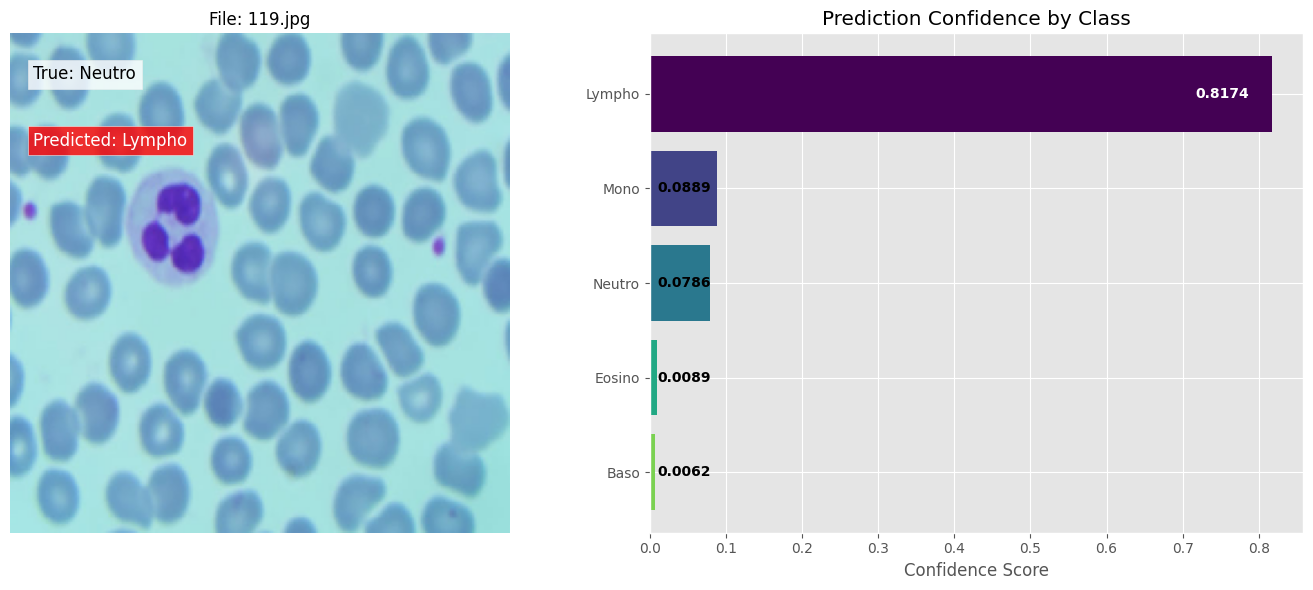

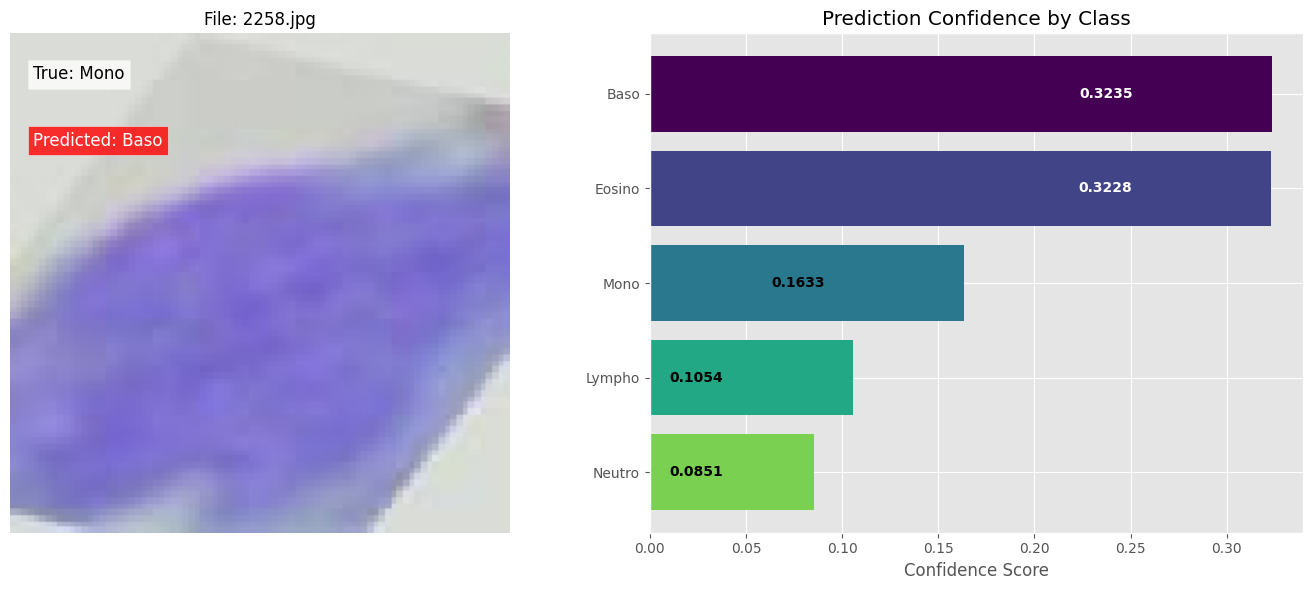

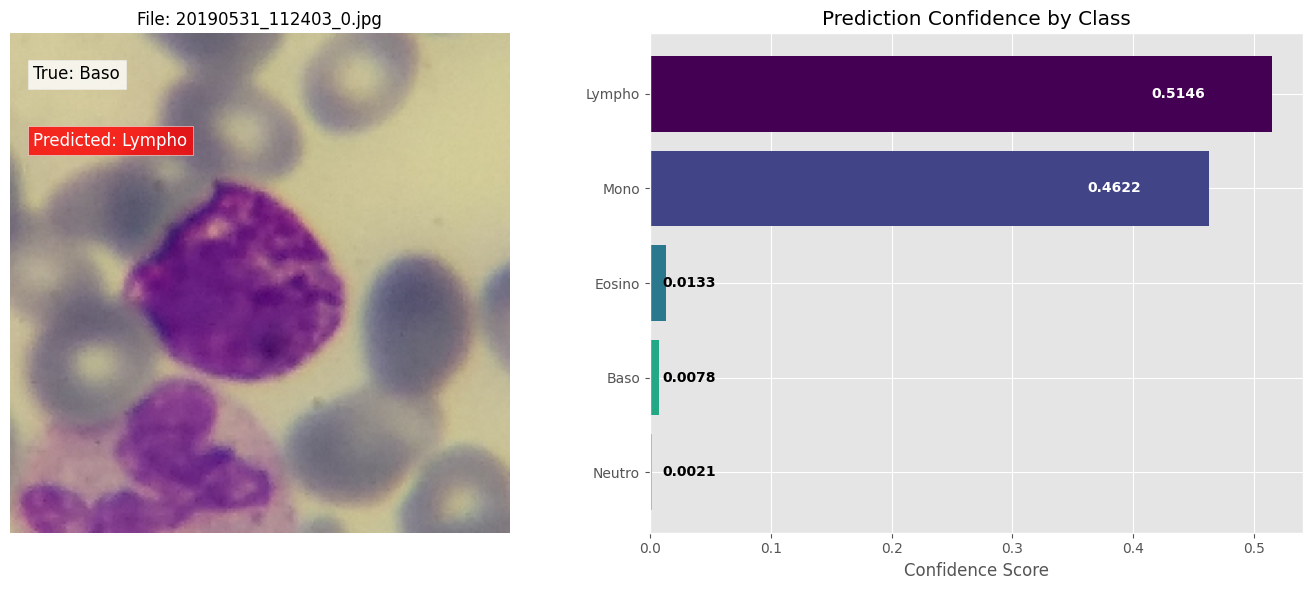

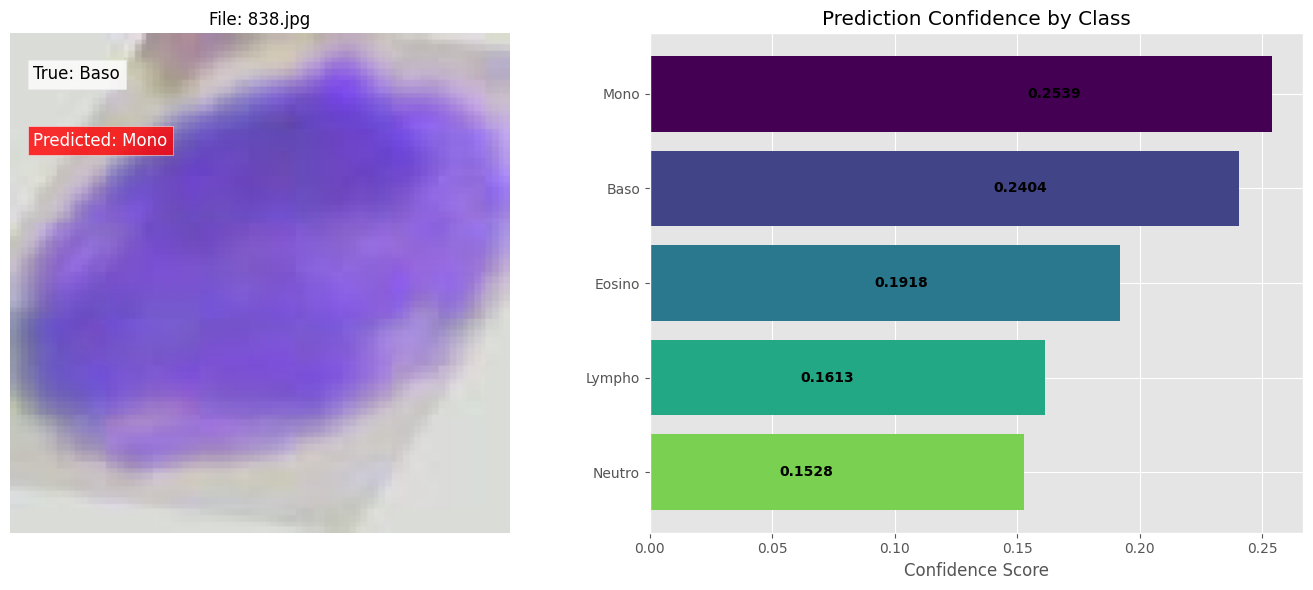

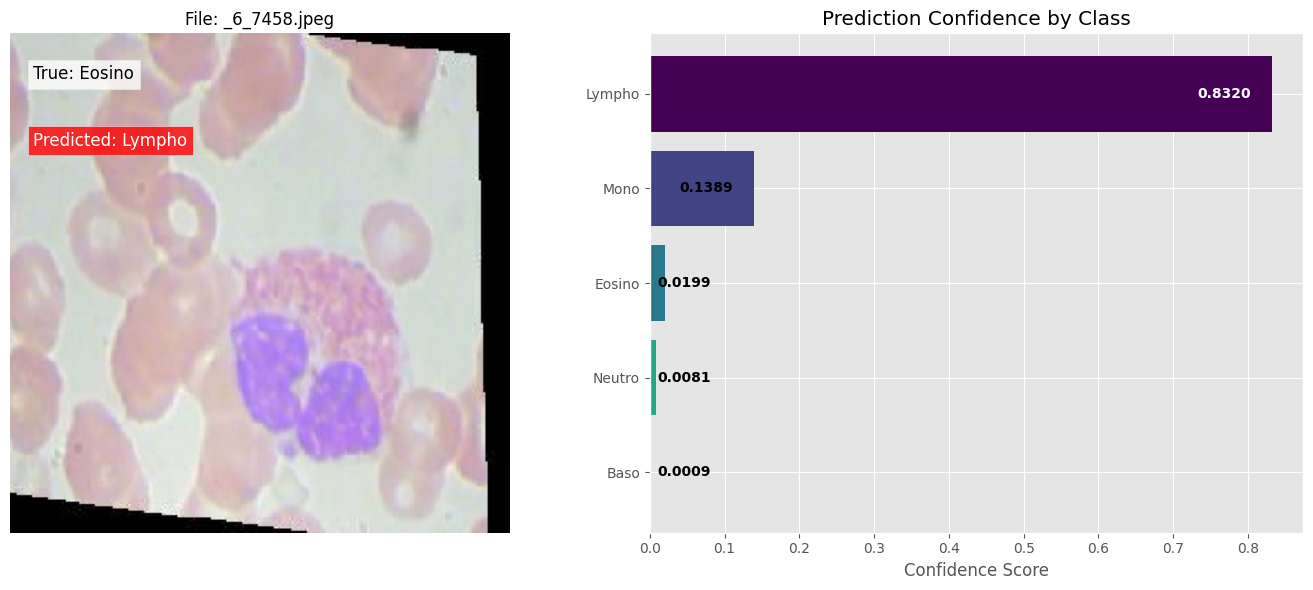

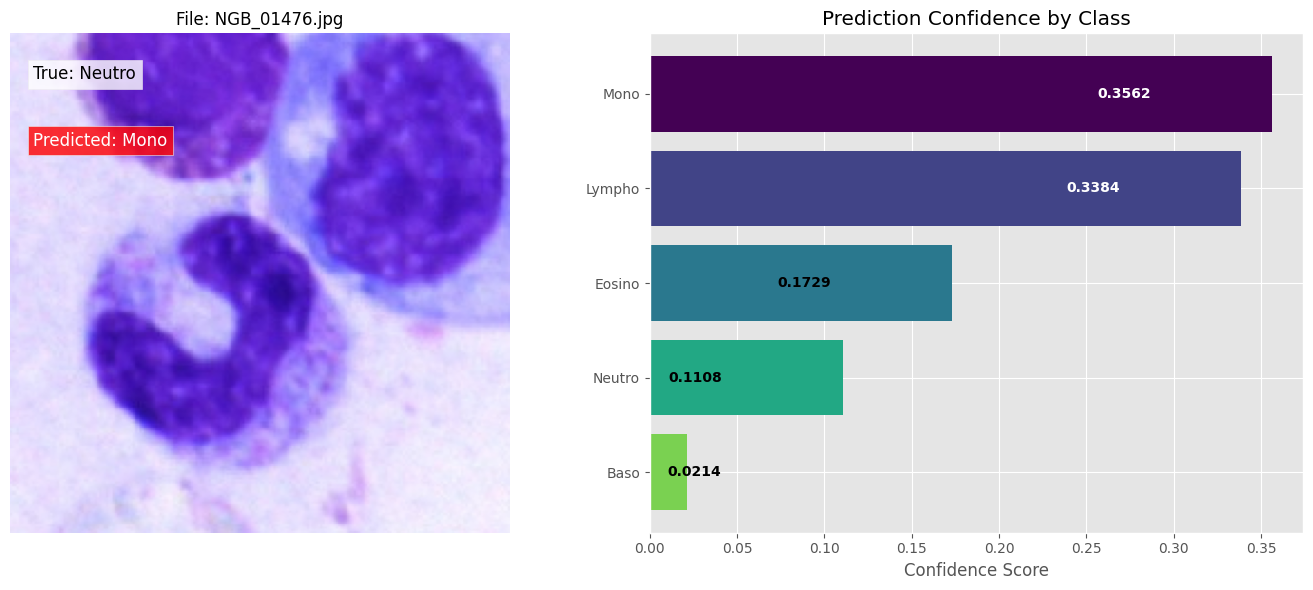

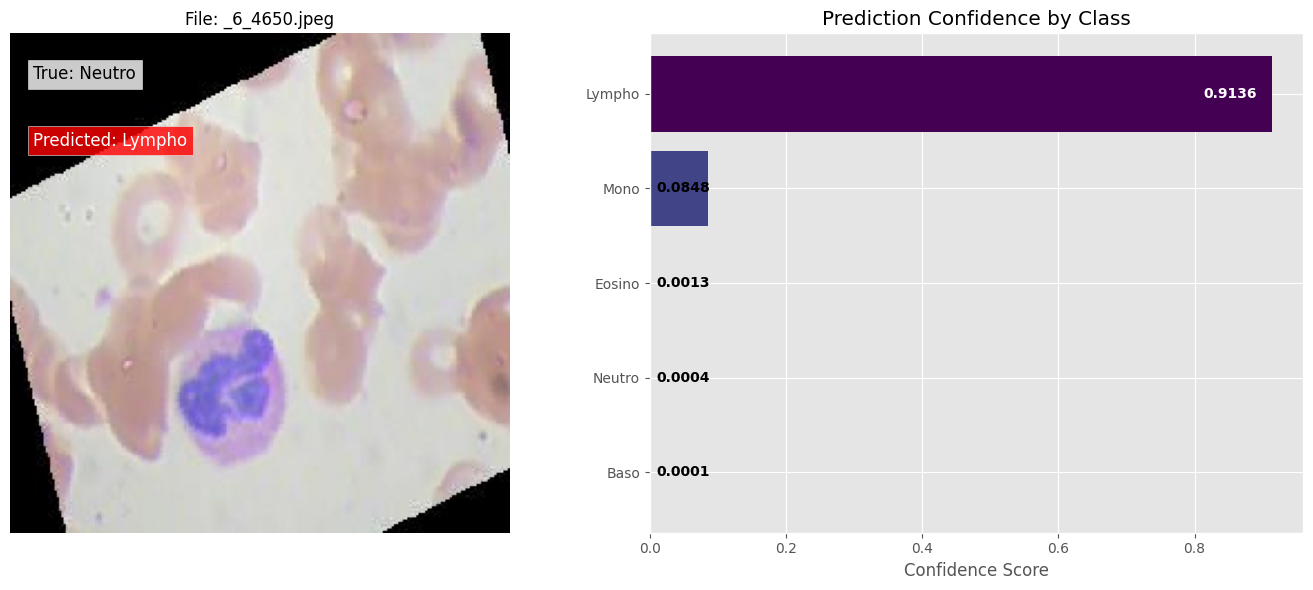

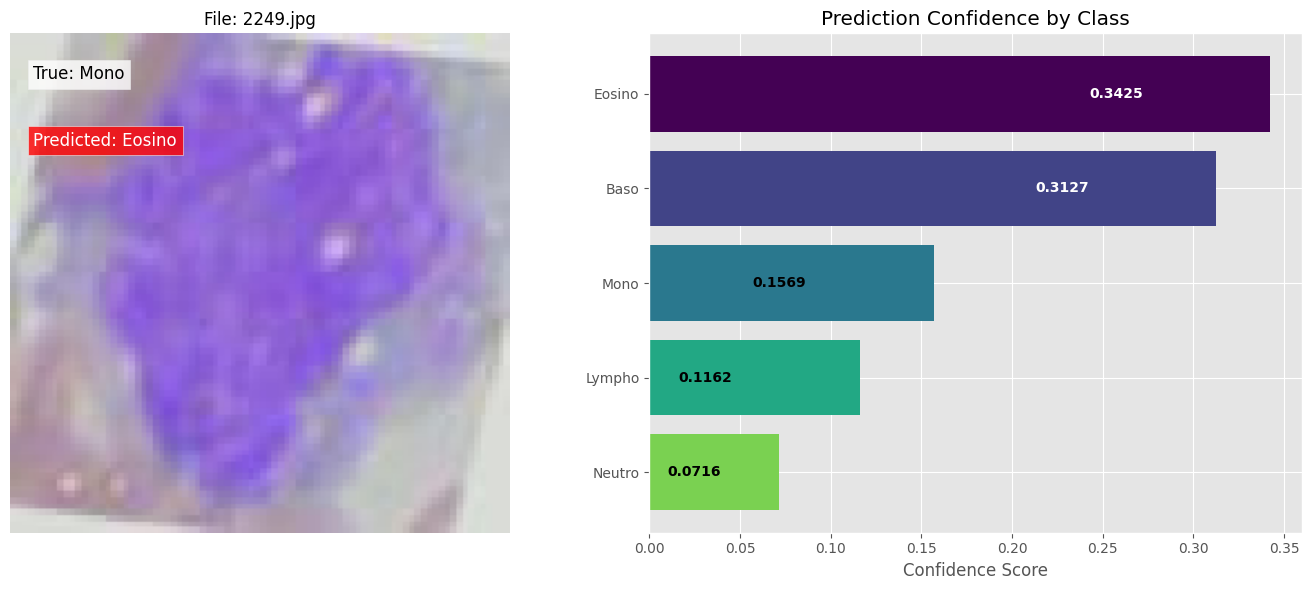

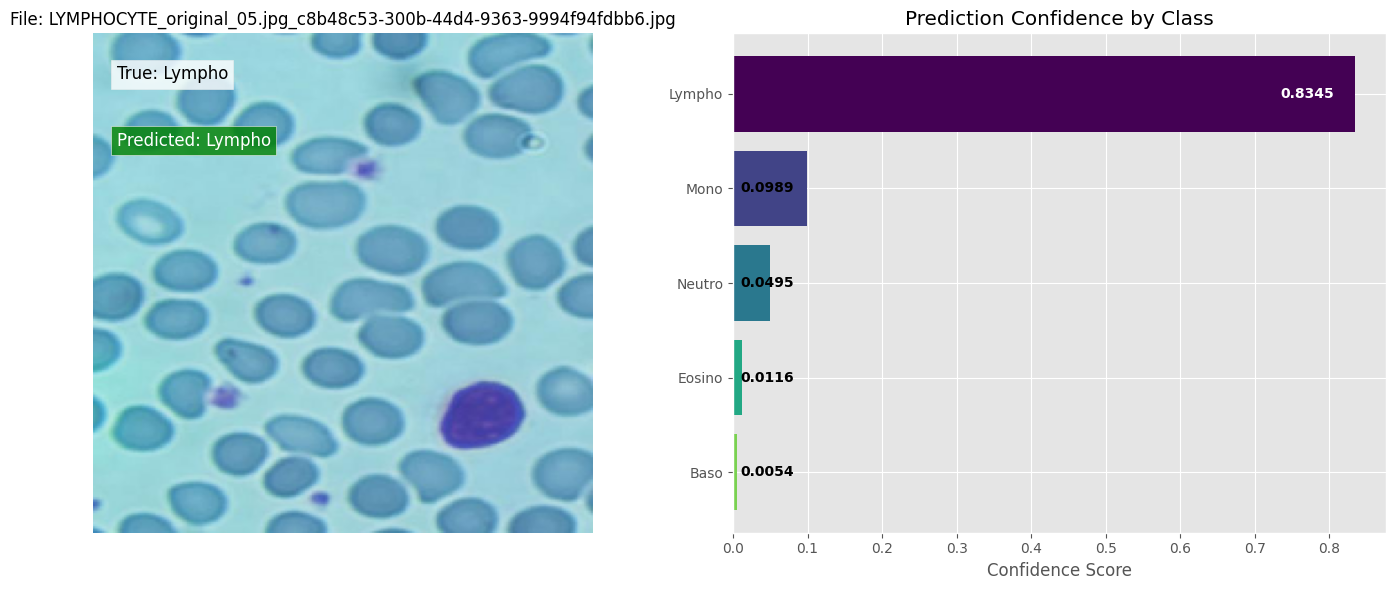

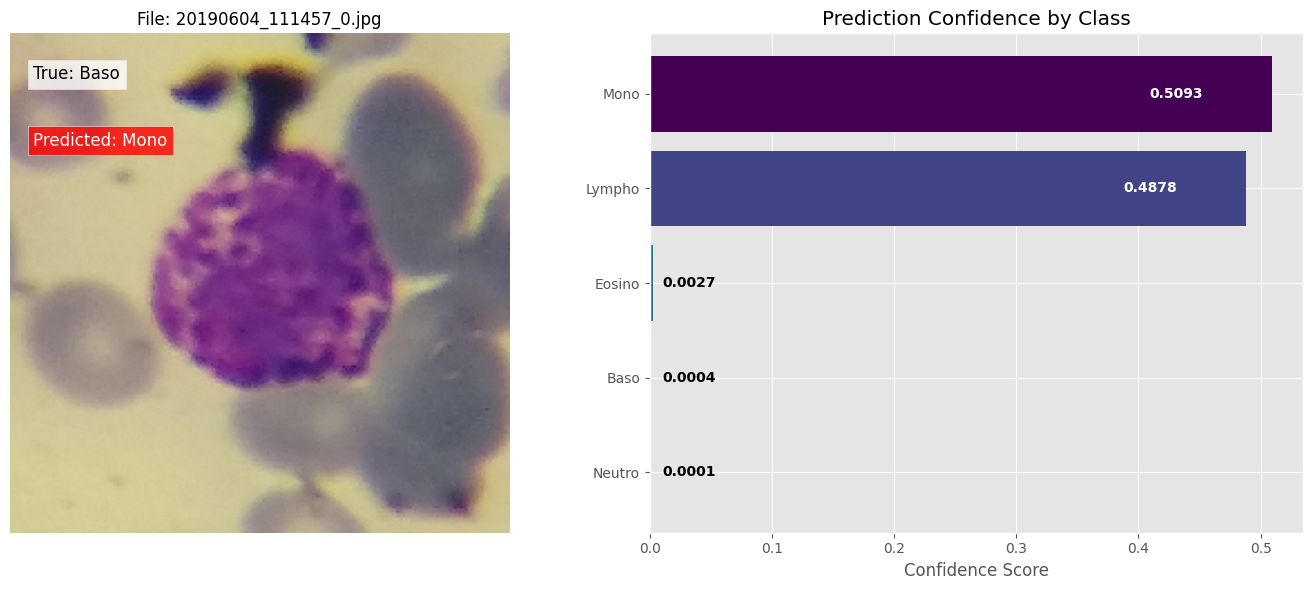

In [55]:
# Display sample predictions
print("\n\nSample Predictions with Confidence Levels:")
visualize_sample_predictions(20)